<a href="https://colab.research.google.com/github/kmsrogerkim/HAI-Intro-to-Torch/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Make Train Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 953kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.27MB/s]


In [ ]:
latent_dim = 100
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # Define the Generator's architecture
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # Define the Discriminator's architecture
    self.model = nn.Sequential(
      nn.Linear(28*28, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
# Loss function
criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

lr = 0.00021

# Optimizers
G_optimizer = torch.optim.Adam(generator.model.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(discriminator.model.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
import torch.autograd as autograd

num_epochs = 10
# Tries to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
criterion.to(device)

# For graphing later on
D_losses = []
G_losses = []
D_real_scores = []
D_fake_scores = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(train_loader):
        # Flatten the images for the Discriminator
        images = images.view(images.size(0), -1).to(device)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        ############################
        # Train the Discriminator
        ############################
        D_optimizer.zero_grad()

        # Compute BCELoss using real images
        outputs = discriminator(images)
        D_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Compute BCELoss using fake images
        outputs = discriminator(fake_images.detach())
        D_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Optimize the Discriminator
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        ############################
        # Train the Generator
        ############################
        G_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Compute BCELoss using fake images, with reversed labels
        outputs = discriminator(fake_images)
        G_loss = criterion(outputs, real_labels)

        # Optimize the Generator
        G_loss.backward()
        G_optimizer.step()

        if (i+1) % 100 == 0:
            D_losses.append(D_loss.item())
            G_losses.append(G_loss.item())
            D_real_scores.append(real_score.mean().item())
            D_fake_scores.append(fake_score.mean().item())

100%|██████████| 10/10 [03:12<00:00, 19.23s/it]


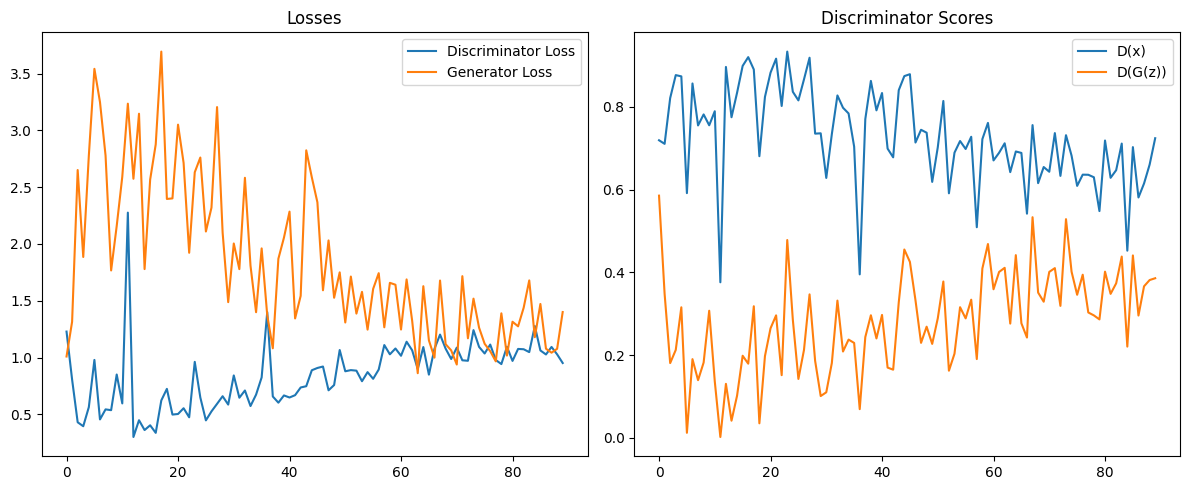

In [ ]:
plt.figure(figsize=(12,5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.title('Losses')
plt.legend()

# Plot Discriminator Scores
plt.subplot(1, 2, 2)
plt.plot(D_real_scores, label='D(x)')
plt.plot(D_fake_scores, label='D(G(z))')
plt.title('Discriminator Scores')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(generator.state_dict(), './generator.pth')

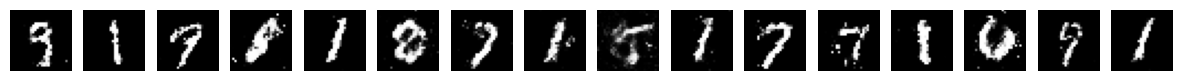

In [ ]:
# Generate fake images for visualization
z = torch.randn(16, latent_dim).to(device)
fake_images = generator(z)
fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
fake_images = (fake_images + 1) / 2  # Rescale images to [0, 1]

# Plot the fake images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 16, figsize=(15, 15))
for ax, img in zip(axes.flatten(), fake_images):
    ax.axis('off')
    ax.set_adjustable('box')
    img = transforms.ToPILImage()(img.cpu().squeeze())
    ax.imshow(img, cmap='gray')
plt.show()